# Imports

In [56]:
# Standard library imports
import joblib

# Third-party imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox, randint, uniform, reciprocal, expon

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Scikit-learn imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit,
                                     GridSearchCV, cross_val_score, RandomizedSearchCV)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder, MinMaxScaler,
                                   Normalizer, OneHotEncoder, OrdinalEncoder, PolynomialFeatures,
                                   PowerTransformer, QuantileTransformer, StandardScaler)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Reading the data

In [57]:
from pathlib import Path

In [58]:
path = (Path('..') / 'Kaggle-Titanic-Spacechip-Competion')

In [59]:
train_data = pd.read_csv(path / 'train.csv')
test_data = pd.read_csv(path / 'test.csv')

In [60]:
test_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


# EDA

### Outliers

KeyError: 'total_spent'

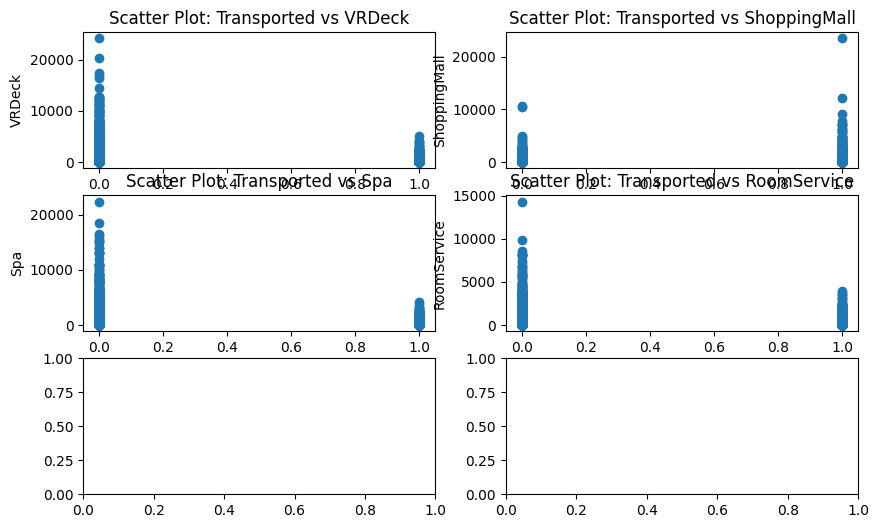

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6))  # Create a figure and a 1x2 subplot

# Plot on the first subplot
axs[0][0].scatter(treated_train_data['Transported'], treated_train_data['VRDeck'])
axs[0][0].set_xlabel('Transported')
axs[0][0].set_ylabel('VRDeck')
axs[0][0].set_title('Scatter Plot: Transported vs VRDeck')

# Plot on the second subplot
axs[0][1].scatter(treated_train_data['Transported'], treated_train_data['ShoppingMall'])
axs[0][1].set_xlabel('Transported')
axs[0][1].set_ylabel('ShoppingMall')
axs[0][1].set_title('Scatter Plot: Transported vs ShoppingMall')

# Plot on the second subplot
axs[1][0].scatter(treated_train_data['Transported'], treated_train_data['Spa'])
axs[1][0].set_xlabel('Transported')
axs[1][0].set_ylabel('Spa')
axs[1][0].set_title('Scatter Plot: Transported vs Spa')

# Plot on the second subplot
axs[1][1].scatter(treated_train_data['Transported'], treated_train_data['RoomService'])
axs[1][1].set_xlabel('Transported')
axs[1][1].set_ylabel('RoomService')
axs[1][1].set_title('Scatter Plot: Transported vs RoomService')

# Plot on the second subplot
axs[2][0].scatter(treated_train_data['Transported'], treated_train_data['total_spent'])
axs[2][0].set_xlabel('Transported')
axs[2][0].set_ylabel('total_spent')
axs[2][0].set_title('Scatter Plot: Transported vs Total Spent')

# Plot on the second subplot
axs[2][1].scatter(treated_train_data['Transported'], treated_train_data['FoodCourt'])
axs[2][1].set_xlabel('Transported')
axs[2][1].set_ylabel('FoodCourt')
axs[2][1].set_title('Scatter Plot: Transported vs FoodCourt')

plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()

In [ ]:
drop_ix_food = treated_train_data[(treated_train_data['FoodCourt']>20000)].index
drop_ix_shopping = treated_train_data[(treated_train_data['ShoppingMall']>10000)].index

treated_train_data = treated_train_data.drop(drop_ix_food)
treated_train_data = treated_train_data.drop(drop_ix_shopping)

### Checking relationships between features

In [ ]:
numerical_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

figsize = (1.5, 1.3)
g = sns.PairGrid(train_data, hue='Transported', vars=numerical_columns, height=figsize[1], aspect=figsize[0]/figsize[1])
g.map_lower(sns.scatterplot)
legend = g.add_legend(loc='upper right', bbox_to_anchor=(0.65, 0.7))

for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)

plt.show()

In [ ]:
y_train = treated_train_data['Transported'].astype(int)
treated_train_data.drop('Transported', axis=1, inplace=True)
treated_train_data.drop('PassengerId', axis=1, inplace=True)
treated_train_data.drop('passenger_group', axis=1, inplace=True)

### Feature Distribution

In [ ]:
# Plot histograms for each variable
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(12, 4))

for i, var in enumerate(numerical_columns):
    axes[i].hist(treated_train_data[var], bins=20, alpha=0.7)
    axes[i].set_title(var)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import PowerTransformer

normalizer_pipeline = Pipeline([
    ('feature_processing', ColumnTransformer([
        ('normalizer', PowerTransformer(method='yeo-johnson'), make_column_selector(dtype_include=float)),
        ('encoder', OneHotEncoder(), make_column_selector(dtype_exclude=np.number))
    ], remainder='passthrough')),
])

treated_train_data = pd.DataFrame(normalizer_pipeline.fit_transform(treated_train_data), 
                                  columns= [col.replace('normalizer__', '').replace('remainder__', '').replace('encoder__', '') for col in normalizer_pipeline.named_steps['feature_processing'].get_feature_names_out()])

treated_test_data = pd.DataFrame(normalizer_pipeline.transform(treated_test_data), 
                                 columns= [col.replace('normalizer__', '').replace('remainder__', '').replace('encoder__', '') for col in normalizer_pipeline.named_steps['feature_processing'].get_feature_names_out()])

In [ ]:
# Plot histograms for each variable
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(12, 4))

for i, var in enumerate(numerical_columns):
    axes[i].hist(treated_train_data[var], bins=20, alpha=0.7)
    axes[i].set_title(var)

plt.tight_layout()
plt.show()

# Data processing

### Tweaking

In [ ]:
# The name of the passengers isn't going to be used for nothing in this notebook
test_data.drop('Name',inplace=True,axis=1)
train_data.drop('Name', axis=1, inplace=True)

# The passenger group was utilized in processing steps so I already added it here to the DataFrame
test_data['passenger_group']=test_data['PassengerId'].apply(lambda x: x[0:4])
train_data['passenger_group']=train_data['PassengerId'].apply(lambda x: x[0:4])

# The passenger IDs will be used at the end to return the correct IDs with the model previsions
test_passenger_id = test_data['PassengerId']
passenger_id = train_data['PassengerId']

In [ ]:
train_data

### Classes and functions

In [ ]:
binary_columns = ['CryoSleep','VIP']
numeric_columns = ['FoodCourt','RoomService','Spa','VRDeck','ShoppingMall']

cabin_ix = 3 # The cabin index is used in the CabinSeparator class

class CabinSeparator(BaseEstimator, TransformerMixin):

    # The Cabin info has the aggregated information of the cabin deck, side and number. This function stores all the information but just returns to the original
    # dataframe the cabin deck and side, given that the number can go until past 1000 and would probably overfit the data and not help very much
    def __init__(self, add_separate_cabin=True):
        self.add_separate_cabin = add_separate_cabin
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.add_separate_cabin:
            X = pd.DataFrame(X)
            cabin_deck = X.iloc[:, cabin_ix].apply(lambda s: str(s).split('/')[0])
            cabin_num = X.iloc[:, cabin_ix].apply(lambda s: str(s).split('/')[0] if len(str(s).split('/'))==1 else str(s).split('/')[1])
            cabin_side = X.iloc[:, cabin_ix].apply(lambda s: str(s).split('/')[0] if len(str(s).split('/'))==1 else str(s).split('/')[2])
            X['cabin_deck'] = cabin_deck
            X['cabin_side'] = cabin_side
            X = X.drop(X.columns[[cabin_ix]], axis=1)
            return X.values
        else:
            return X
    def get_feature_names_out(self):
        return ['cabin_deck','cabin_num','cabin_side']


class FillBinaryNumericTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # I am assuming here that if there is no record of the person in CryoSleep or if they are on the VIP list they probably aren't in neither
        X.loc[:, binary_columns] = X[binary_columns].fillna(False)
        # The same logic applies here, if there is no record of the passenger spending money, they probably didn't spend it
        X.loc[:, numeric_columns] = X[numeric_columns].fillna(0)
        return X

class FillCabinDestHomeAgeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Here the function groups the data by the passanger group, and fills in the other data based on the info of another passanger that's in their group
        # For example if the daughter didn't put her data correct but her mother did, the code will retrieve that information
        X['Cabin'] = X.groupby('passenger_group')['Cabin'].transform(lambda x: x.fillna(x.iloc[0]))
        X['Destination'] = X.groupby('passenger_group')['Destination'].transform(lambda x: x.fillna(x.iloc[0]))
        X['HomePlanet'] = X.groupby('passenger_group')['HomePlanet'].transform(lambda x: x.fillna(x.iloc[0]))
        X['Age'] = X.groupby('passenger_group')['Age'].transform(lambda value: value.fillna(value.mean()))
        return X

class FillRestTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # For the groups that didn't have any information, I just decided to fill in the Age with the mean of values from that group and the other just a 'None' string
        X['Age'] = X.groupby('passenger_group')['Age'].transform(lambda value: value.fillna(value.mean()))
        X['Age'] = X['Age'].transform(lambda value: value.fillna(value.mean()))
        X[['Cabin','HomePlanet','Destination']] = X[['Cabin','HomePlanet','Destination']].fillna('None')
        return X

class AddTotalSpent(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        total_spent = np.sum(X[:, 5:10], axis=1)
        X = np.column_stack((X, total_spent))
        return X

class AddPolyFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree=3, addpoly=True):
        self.degree = degree
        self.addpoly = addpoly
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=False)

    def fit(self, X, y=None):
        if self.addpoly:
            self.poly.fit(X)
        return self

    def transform(self, X):
        if self.addpoly:
            return self.poly.transform(X)
        else:
            return X

    def get_feature_names_out(self, input_features=None):
        """Ensure feature names are passed through correctly"""
        if self.addpoly:
            return self.poly.get_feature_names_out(input_features)
        return np.array(input_features) if input_features is not None else np.array([])

In [ ]:
train_column_names = [col for col in train_data.columns if col != 'Cabin'] + ['cabin_deck','cabin_side','total_spent']
test_column_names = [col for col in test_data.columns if col != 'Cabin'] + ['cabin_deck','cabin_side','total_spent']

preprocessing = Pipeline([
    ('binary_numeric', FillBinaryNumericTransformer()),
    ('cabin_dest_home_age', FillCabinDestHomeAgeTransformer()),
    ('rest', FillRestTransformer()),
    ('cabin_separator', CabinSeparator()),
    ('add_total_spent', AddTotalSpent()),
])

treated_train_data = pd.DataFrame(preprocessing.fit_transform(train_data), columns=train_column_names)
treated_test_data = pd.DataFrame(preprocessing.transform(test_data), columns=test_column_names)

columns_to_convert = ['total_spent', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Convert columns to numeric type
treated_train_data[columns_to_convert] = treated_train_data[columns_to_convert].apply(pd.to_numeric, errors='coerce')
treated_test_data[columns_to_convert] = treated_test_data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

treated_train_data[['VIP','CryoSleep']] = treated_train_data[['VIP','CryoSleep']].astype(int)
treated_test_data[['VIP','CryoSleep']] = treated_test_data[['VIP','CryoSleep']].astype(int)

In [ ]:
numeric_cols = treated_train_data[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','total_spent']]
numeric_cols.head()

# Model

In [ ]:
treated_train_data_ = treated_train_data.drop(['PassengerId','passenger_group'], axis=1)
treated_test_data = treated_test_data.drop(['PassengerId','passenger_group'], axis=1)

y_train = treated_train_data_['Transported']

treated_train_data_dropped = treated_train_data_.drop(['Transported'], axis=1)

In [ ]:
# First, split the data into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(treated_train_data_dropped, y_train, test_size=0.2, random_state=42)

# Then, split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

In [ ]:
X_train

def create_inverse(X):

    X['1/Age'] = 1/(X['Age']+0.001)
    X['1/RoomService'] = 1/(X['RoomService']+0.001)
    X['1/FoodCourt'] = 1/(X['FoodCourt']+0.001)
    X['1/ShoppingMall'] = 1/(X['ShoppingMall']+0.001)
    X['1/Spa'] = 1/(X['Spa']+0.001)
    X['1/VRDeck'] = 1/(X['VRDeck']+0.001)

    return X

X_train = create_inverse(X_train)
X_val = create_inverse(X_val)
X_test = create_inverse(X_test)
treated_test_data = create_inverse(treated_test_data)

X_train

### Create new features

### PCA Pipeline

In [ ]:
# Define the preprocessing pipelines for numeric and categorical data
numeric_pipeline = Pipeline(steps=[
    ('pca', PCA(n_components=0.865)),
    ('add_poly', AddPolyFeatures()),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Combine numeric and categorical pipelines using make_column_selector
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, make_column_selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_pipeline, make_column_selector(dtype_include='object'))
    ]
)

# Define the final pipeline including the preprocessor and the quantile transformer
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('quantile', QuantileTransformer(output_distribution='normal'))
])

# Fit the pipeline to the training data
final_pipeline.fit(X_train)

In [ ]:
other_feat = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spent']

other_feat_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('quantile', QuantileTransformer(output_distribution='normal'))
])

# Combine the preprocessing steps using ColumnTransformer
other_feat_preprocessor = ColumnTransformer(
    transformers=[
        ('scale_quantile', other_feat_pipeline, other_feat)
    ],
    remainder='passthrough'  # Keep the remaining columns unchanged
)

# Define the final pipeline
other_feat_final_pipeline = Pipeline(steps=[
    ('preprocessor', other_feat_preprocessor)
])

other_feat_final_pipeline.fit(X_train[other_feat])

In [ ]:
X_train

In [ ]:
X_val

### Apply the pipelines

In [ ]:
X_train_transformed = final_pipeline.transform(X_train)

X_val_transformed = final_pipeline.transform(X_val)

X_test_transformed = final_pipeline.transform(X_test)

transformed_test_data = final_pipeline.transform(treated_test_data)

print("Transformed shape:", X_train_transformed.shape)
print("Feature names shape:", len(final_pipeline.get_feature_names_out()))

In [ ]:
X_train_treated = pd.DataFrame(X_train_transformed, columns=final_pipeline.get_feature_names_out())

X_val_treated = pd.DataFrame(X_val_transformed, columns=final_pipeline.get_feature_names_out())

X_test_treated = pd.DataFrame(X_test_transformed, columns=final_pipeline.get_feature_names_out())

test_data = pd.DataFrame(transformed_test_data, columns=final_pipeline.get_feature_names_out())

other_X_train = pd.DataFrame(other_feat_final_pipeline.transform(X_train[other_feat]), columns=other_feat_final_pipeline.get_feature_names_out())

other_X_val = pd.DataFrame(other_feat_final_pipeline.transform(X_val[other_feat]), columns=other_feat_final_pipeline.get_feature_names_out())

other_X_test = pd.DataFrame(other_feat_final_pipeline.transform(X_test[other_feat]), columns=other_feat_final_pipeline.get_feature_names_out())

other_test_data = pd.DataFrame(other_feat_final_pipeline.transform(treated_test_data[other_feat]), columns=other_feat_final_pipeline.get_feature_names_out())

X_train = pd.concat([X_train_treated, other_X_train], axis=1)
X_val = pd.concat([X_val_treated, other_X_val], axis=1)
X_test = pd.concat([X_test_treated, other_X_test], axis=1)
final_test = pd.concat([test_data, other_test_data], axis=1)

In [ ]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [ ]:
X_train

In [ ]:
X_test

#### Load models

In [ ]:
gbc_model = joblib.load('best_gbc_model.pkl')
lr_model = joblib.load('best_lr_model.pkl')
svc_model = joblib.load('best_svc_model.pkl')
xgb_model = joblib.load('best_xgb_model.pkl')
stacking_clf = joblib.load('stacking_clf.pkl')

In [ ]:
gbc_model.fit(X_train, y_train)

In [ ]:
svc_model.fit(X_train, y_train)

In [ ]:
lr_model.fit(X_train, y_train)

In [ ]:
xgb_model.fit(X_train, y_train)

In [ ]:
stacking_clf.fit(X_train, y_train)

In [ ]:
def accuracy_check(model, X_val, y_val):

    y_pred = model.predict(X_val)
    eval_accuracy = accuracy_score(y_val, y_pred, )

    return eval_accuracy

In [ ]:
accuracy_check(stacking_clf, X_val, y_val)

In [ ]:
accuracy_check(gbc_model, X_val, y_val)

In [ ]:
accuracy_check(xgb_model, X_val, y_val)

In [ ]:
accuracy_check(lr_model, X_val, y_val)

In [ ]:
accuracy_check(svc_model, X_val, y_val)

In [ ]:
stacking_clf = StackingClassifier(

    estimators=[
        ('xgb', xgb_model),
        ('lr', lr_model),
        ('svc', svc_model),
        ('gbc', gbc_model)
    ],
    cv = 5
)

stacking_clf.fit(X_train, y_train)
accuracy_check(stacking_clf, X_val, y_val)
#joblib.dump(stacking_clf, 'stacking_clf.pkl')

In [ ]:
stacking_clf.predict_proba(X_val)

In [ ]:
accuracy_check(stacking_clf, X_val, y_val)

In [ ]:
stacking_clf.predict(X_test)

In [ ]:
pd.DataFrame(stacking_clf.predict(final_test).astype(bool),test_passenger_id, columns=['Transported']).to_csv(path / 'pred_5.csv')

In [ ]:
print(stacking_clf.predict(final_test))

In [ ]:
misclassified_indices = np.where(y_val != stacking_clf.predict(X_val))[0]
misclassified_samples = treated_train_data.iloc[misclassified_indices]
misclassified_samples

In [ ]:
misclassified_samples.VIP.value_counts()

In [ ]:
misclassified_samples.Destination.value_counts()

In [ ]:
misclassified_samples.HomePlanet.value_counts()